In [22]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
from torch.autograd import Variable
import pandas
from sklearn.preprocessing import MinMaxScaler
import torchvision.models as models
import torchvision.transforms as transforms
import torch
from torch.autograd import Variable
import numpy as np
from PIL import Image
import copy

from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (8.0, 10.0)
from torch.utils.data import Dataset, DataLoader

from dataset import MSCOCODataset

import nltk
from IPython.display import display

In [2]:
dataDir='/home/p.zaydel/ProjectNeuralNets/coco_dataset/'
imagesDirTrain = '{}train2017/train2017'.format(dataDir)
imagesDirVal = '{}val2017/val2017'.format(dataDir)

annTrainFile = '{}/annotations_trainval2017/annotations/captions_train2017.json'.format(dataDir)
annValFile = '{}/annotations_trainval2017/annotations/captions_val2017.json'.format(dataDir)

In [3]:
transform_tensor = transforms.Compose([
                                transforms.ToTensor(), 
                                transforms.Normalize(
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                                           ])
transform_to224 = transforms.Compose([transforms.Resize((224, 224)),
                                      transform_tensor
                                     ])
transform_to500 = transforms.Compose([ transforms.Resize((500, 500)),
                                      transform_tensor
                                           ])

In [4]:
trainDataset = MSCOCODataset(annTrainFile,imagesDirTrain, transform = transform_to500, mode='pic2rand')
testDataset = MSCOCODataset(annValFile,imagesDirVal, transform = transform_to500, mode='pic2rand')

loading annotations into memory...
Done (t=1.16s)
creating index...
index created!
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


A group of people sitting at desk using computers.
554625


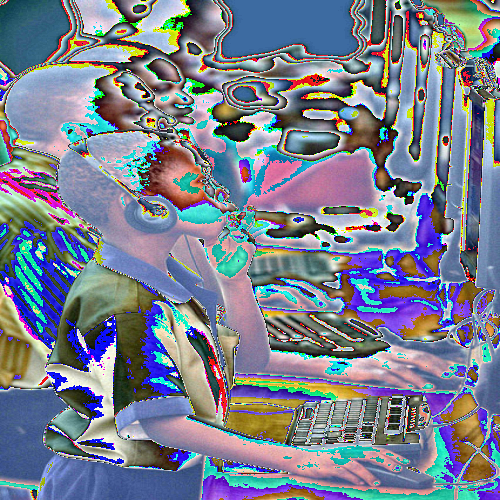

In [8]:
idx = 4
print(trainDataset[idx]['anns'])
print(trainDataset[idx]['imid'])
transforms.ToPILImage()(trainDataset[idx]['image'])

In [17]:
anns_lens = []
for idx in range(len(trainDataset)):
    sample = trainDataset.get_item_data(idx)
    anns_lens.append(len(sample['anns']))
anns_lens = np.array(anns_lens)
uniq = list(np.unique(anns_lens))

print("Train len(anns) ")
for v in uniq:
    print(v, ": ", anns_lens[anns_lens == v].shape[0])

Train len(anns) 
5 :  117972
6 :  312
7 :  3


In [18]:
anns_lens = []
for idx in range(len(testDataset)):
    sample = testDataset.get_item_data(idx)
    anns_lens.append(len(sample['anns']))
anns_lens = np.array(anns_lens)
uniq = list(np.unique(anns_lens))
print("Test len(anns) ")
for v in uniq:
    print(v, ": ", anns_lens[anns_lens == v].shape[0])

Test len(anns) 
5 :  4987
6 :  12
7 :  1


In [ ]:
# Оставим только изображения с 

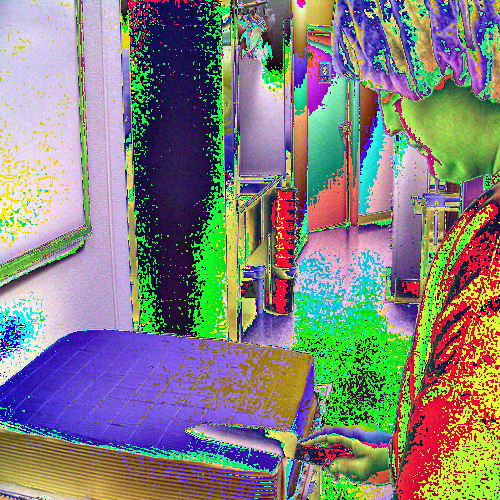

In [19]:
transforms.ToPILImage()(trainDataset[1]['image'])

In [12]:
trainDataLoader = DataLoader(trainDataset, batch_size = 64, shuffle=True)
testDataLoader = DataLoader(testDataset, batch_size = 64, shuffle=True)


In [18]:
def anns_to_texts(anns_list):
    texts = []
    for anns in anns_list:
        for ann in anns['anns']:
            texts.append(nltk.word_tokenize(ann.lower()))
    return texts

In [19]:
from gensim.models import Word2Vec
def train_word_to_vec_gensim(dataset, embed_size = 4096):
    Anns = dataset.get_anns()
    Texts = anns_to_texts(Anns)
    model = Word2Vec(trainTexts, size = embed_size)
    return model

In [39]:
def generate_vocab_dicts(dataset):
    Anns = dataset.get_anns()
    Texts = anns_to_texts(Anns)
    uniqwords = list(set([w for ann in Texts for w in ann]))
    words2ids = dict(zip(uniqwords, range(len(uniqwords))) )
    ids2words = dict(zip(range(len(uniqwords)), uniqwords ))
    return words2ids, ids2words

In [40]:
words2ids, ids2words  = generate_vocab_dicts(trainDataset)

In [44]:
word_embeding = train_word_to_vec_gensim(trainDataset, embed_size = 4096 )

In [45]:
vec = word_embeding['.']
print(vec)
word_embeding.wv.similar_by_vector(vec)

/home/p.zaydel/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


[ 0.03817174  0.22131363 -0.01423428 ... -0.25163153  0.01226607
 -0.08465472]


[('.', 1.0),
 ('shrubbery', 0.3877374529838562),
 ('hedge', 0.3840276598930359),
 ('bush', 0.3703567683696747),
 ('fencing', 0.3453886806964874),
 ('heat', 0.34482884407043457),
 ('shrubs', 0.3357311487197876),
 ('shed', 0.3333032727241516),
 ('forest', 0.33076155185699463),
 ('hills', 0.3243764340877533)]

In [114]:
len(words2ids)

29558

In [63]:
image_size = 500
hidden_size = get_alexnet_features_dim(image_size)
word_embeding_size = word_embeding.trainables.layer1_size
sentence_end_embed = word_embeding['.']
cnn = models.alexnet(pretrained=True)

/home/p.zaydel/conda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [155]:
lstmnet = LSTM_W2V_Net(image_size, hidden_size , word_embeding,
                     word_embeding_size, words2ids, ids2words, 
                     cnn = cnn,
                     max_sentence_len = 20,
                     sentence_end_embed = sentence_end_embed)

In [148]:
hidden_size

50176

In [140]:
for sample in trainDataLoader:
    break


In [157]:
# X = lstmnet.cnn.features(Variable(sample['image']))
# X = X.view(X.shape[0], hidden_size)
# X

In [147]:
64*256*14*14

50176

In [158]:
sample = trainDataset[0]
lstmnet.forward(Variable(sample['image'].unsqueeze(0)))

torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])
torch.Size([1, 4096])


Variable containing:
( 0  ,.,.) = 
  8.3940e-02  7.3661e-02 -5.4811e-02  ...  -2.2904e-02 -3.9203e-02  1.5361e-02
  9.6983e-02  8.1832e-02 -6.4420e-02  ...  -3.1240e-02 -4.5691e-02  1.4471e-02
  1.0467e-01  8.5508e-02 -6.8998e-02  ...  -3.6908e-02 -4.9305e-02  1.3479e-02
                 ...                   ⋱                   ...                
  1.1761e-01  8.8841e-02 -7.0842e-02  ...  -4.6404e-02 -5.6077e-02  1.3433e-02
  1.1761e-01  8.8838e-02 -7.0836e-02  ...  -4.6406e-02 -5.6081e-02  1.3432e-02
  1.1761e-01  8.8835e-02 -7.0832e-02  ...  -4.6407e-02 -5.6083e-02  1.3430e-02
[torch.FloatTensor of size 1x20x4096]

In [42]:
# word_to_ix = {"hello": 0, "world": 1}
# embeds = nn.Embedding(2, 5)  # 2 words in vocab, 5 dimensional embeddings 
# hello_embed = embeds(torch.LongTensor([word_to_ix["hello"]]))
# print(hello_embed)

In [154]:
import numpy as np
# calculates dimension of alexnet convolutions layers output 
def get_alexnet_features_dim(imsize):
    adim = int(np.round( 3*0.01*imsize - 1))
    return 1*256*adim*adim


class LSTM_W2V_Net(nn.Module):

    def __init__(self,  image_size, image_features_size, word_embedding, 
                 word_embedding_size, words2ids, ids2words,
                 
                 cnn = models.alexnet(pretrained=True), 
                 cnn_comp_features = lambda cnn, x: cnn.features(x),
                 max_sentence_len = 20,
                 sentence_end_embed = None
                  ):
        """Init NN
            image_size - size of input image.
            hidden_size - size of cnn features output
            word_embedding - pretrained model wor word embedding
            word_embedding_size - dimension of embedding space
            words2ids - dictionary word -> id
            ids2words - dictionary id -> word
            cnn - pretrained cnn net (alexnet, vgg and other)
            cnn_comp_features - function computes features with cnn
            max_sentence_len - maximum sentence length when lstm stops
        """
        
        super(LSTM_W2V_Net, self).__init__()
        self.image_size = image_size
        self.image_features_size = image_features_size
        self.cnn = cnn
        self.cnn_comp_features = cnn_comp_features
        
        self.vocab_size = len(words2ids)
        self.word_embedding_size = word_embedding_size
        self.words_embedding = word_embedding
        
        self.words2ids = words2ids
        self.ids2words = ids2words
        
        if sentence_end_embed is not None:
            self.sentence_end_embed = sentence_end_embed
        else:
            self.sentence_end_embed = word_embeding['.']
        
        self.max_sentence_len = max_sentence_len
        self.hidden_size = word_embedding_size  
        self.fc1 = nn.Sequential( nn.Linear(self.image_features_size, int(self.image_features_size/2)),
                                  nn.ReLU(),
                                  nn.Dropout(),
                                  nn.Linear(int(self.image_features_size/2), int(self.image_features_size/4) ),
                                  nn.ReLU(),
                                  nn.Dropout(),
                                  nn.Linear(int(self.image_features_size/4), self.hidden_size)
                                )
        
        self.fc2 = nn.Sequential(nn.Linear(self.hidden_size, self.vocab_size ))
        
                               
        self.lstm_cell = nn.LSTMCell(self.hidden_size, self.hidden_size)
        #self.lstm = nn.LSTM(hidden_size, word_embedding_size)
    
#     def embed2words(self, embed):
        
    
    def forward(self, X):
        # get features from images
        batch_size = X.shape[0]
        X = self.cnn.features(X)
        X = X.view(batch_size, hidden_size)
        
        h_t = Variable(torch.zeros(batch_size, self.hidden_size), requires_grad=False)
        c_t = Variable(torch.zeros(batch_size, self.hidden_size), requires_grad=False) 
        
        X = self.fc1.forward(X)
        
        h_t, c_t = self.lstm_cell.forward(X, (h_t, c_t))
        
        output = []
        for idx in range(self.max_sentence_len):
            h_t, c_t = self.lstm_cell.forward(X, (h_t, c_t))
            
            print(h_t.shape)
            #r = self.fc2.forward(h_t)
            output.append(h_t)
            
        
        output = torch.stack(output, 1)
        return output

In [ ]:
# TODO train procedure
def train(network, epochs, learning_rate, transform,  loss = MSELoss(), optim=torch.optim.Adam ):
    train_loss_epochs = []
    test_loss_epochs = []
    optimizer = optim(network.parameters(), lr=learning_rate)
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for sample in train_dataloader:
                X = sample['image']
                X = Variable(transform(X)).cuda()
                y = sample['anns']
                
                # так как у каждого изображения несколько аннотаций
                for ann in anns:
                    y = Variable(y.view(y.shape[0], -1)).cuda()
                
                    prediction = network(X)
                    loss_batch = loss(prediction, y)
                    losses.append(loss_batch.data[0])
                    optimizer.zero_grad()
                    loss_batch.backward()
                    optimizer.step()
  
            train_loss_epochs.append(np.mean(losses))
            losses = []    
            for sample in test_dataloader:
                X = sample['image']
                X = Variable(transform(X)).cuda()
                y = sample['anns']
                # у каждого изображения несколько аннотаций, поэтому надо аккуратно вычислять скор
                
                y = Variable(y.view(y.shape[0], -1)).cuda()
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                
            test_loss_epochs.append(np.mean(losses))
            sys.stdout.write('\rEpoch {0}... (Train/Test) MSE: {1:.3f}/{2:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.plot(train_loss_epochs[1:], label='Train')
    plt.plot(test_loss_epochs[1:], label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()